In [1]:
%load_ext line_profiler
%load_ext memory_profiler

%matplotlib inline

In [2]:
%load_ext autoreload
%autoreload 2

In [41]:
import util
import models

from os.path import expanduser
from os import path
import logging

logging.basicConfig(level=logging.DEBUG)

import matplotlib.pyplot as plt
import seaborn as sns

import yass
from yass import read_config, preprocess
from yass.augment import make_training_data, make
from yass.neuralnetwork import NeuralNetDetector, NeuralNetTriage, AutoEncoder 
from yass.explore import RecordingExplorer, SpikeTrainExplorer

import numpy as np
from scipy.io import loadmat

from dstools import plot

In [4]:
yass.set_config("../config/49-lab.yaml")
CONFIG = read_config()

In [5]:
path_to_data = path.expanduser('~/data')
path_to_ground_truth = path.join(path_to_data,
                                 'groundtruth_ej49_data1_set1.mat')
path_to_standarized = path.join(path_to_data, 'tmp', 'preprocess',
                               'standarized.bin')
path_to_geom = path.join(path_to_data, 'ej49_geometry1.txt')

In [29]:
# load ground truth
_ = loadmat(path_to_ground_truth)
gt = np.hstack([_['spt_gt'], _['L_gt']])

gt = gt[2:-1]
gt[:, 1] = gt[:, 1] - 1

# compensate alignment
# gt[:, 0] = gt[:, 0] + 5

In [30]:
# explorer for standarized data
re = RecordingExplorer(path_to_standarized,
                       path_to_geom=path_to_geom,
                       n_channels=49,
                       spike_size=40,
                       neighbor_radius=70,
                       dtype='float32',
                       data_order='samples')

# compute templates for ground truth
se = SpikeTrainExplorer(gt, re)

## Cropping and aligning

In [31]:
se.templates.shape

(49, 81, 49)

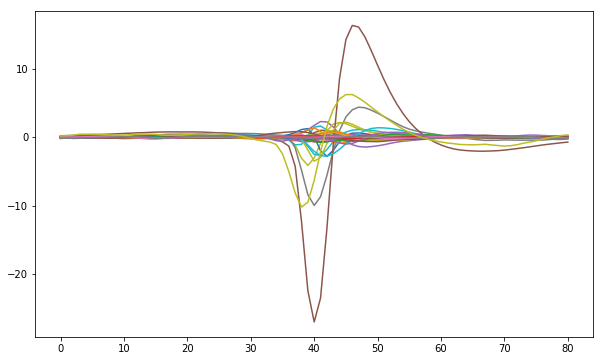

In [36]:
_ = plt.plot(se.templates[10])

In [40]:
from yass.templates.crop import crop_and_align_templates

In [42]:
cropped = crop_and_align_templates(se.templates, 5,
                                   CONFIG.neigh_channels,
                                   CONFIG.geom)
print(se.templates.shape, cropped.shape)

DEBUG:yass.templates.crop:Template 0 will be shifted by 0
DEBUG:yass.templates.crop:Template 1 will be shifted by 2
DEBUG:yass.templates.crop:Template 2 will be shifted by 1
DEBUG:yass.templates.crop:Template 3 will be shifted by 1
DEBUG:yass.templates.crop:Template 4 will be shifted by 1
DEBUG:yass.templates.crop:Template 5 will be shifted by 1
DEBUG:yass.templates.crop:Template 6 will be shifted by 0
DEBUG:yass.templates.crop:Template 7 will be shifted by 1
DEBUG:yass.templates.crop:Template 8 will be shifted by 1
DEBUG:yass.templates.crop:Template 9 will be shifted by 0
DEBUG:yass.templates.crop:Template 10 will be shifted by 1
DEBUG:yass.templates.crop:Template 11 will be shifted by 1
DEBUG:yass.templates.crop:Template 12 will be shifted by 2
DEBUG:yass.templates.crop:Template 13 will be shifted by 0
DEBUG:yass.templates.crop:Template 14 will be shifted by 0
DEBUG:yass.templates.crop:Template 15 will be shifted by 2
DEBUG:yass.templates.crop:Template 16 will be shifted by 1
DEBUG:y

(49, 81, 49) (49, 31, 7)


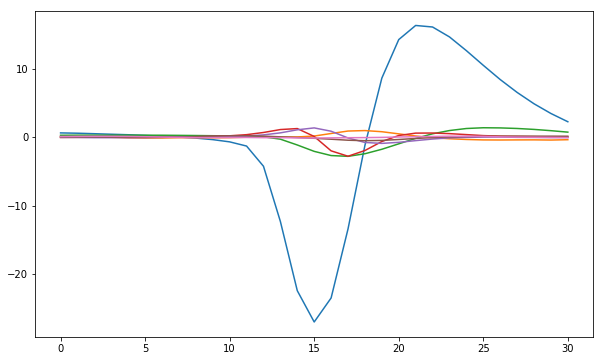

In [43]:
_ = plt.plot(cropped[10])

## Inspecting ground truth amplitudes and templates

In [10]:
def spike_amplitudes_from_spikes(spikes):
    abs_value = np.abs(spikes)
    
    amplitudes = np.max(abs_value, axis=(1, 2))
    main_channels = np.argmax(np.max(abs_value, axis=1), axis=1)

    return amplitudes, main_channels

In [11]:
templates = np.copy(se.templates)
templates = np.concatenate((templates, np.zeros((49, 21, 1))), axis=2)

In [12]:
amps, main_channels = spike_amplitudes_from_spikes(se.templates)

In [13]:
print(amps[2], main_channels[2])

13.871453 25


/home/Edu/miniconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


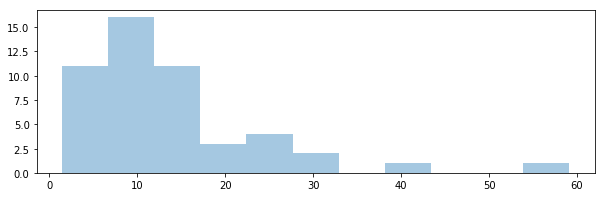

In [14]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps, kde=False)

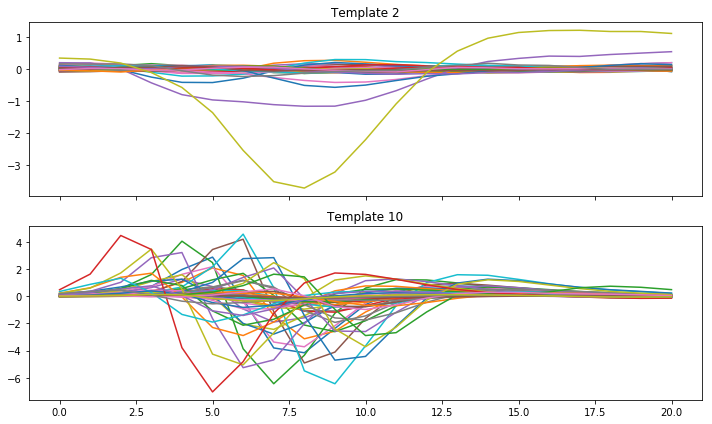

In [15]:
# this looks wrong
plt.rcParams['figure.figsize'] = (10, 6)
se.plot_templates(group_ids=[2, 10])

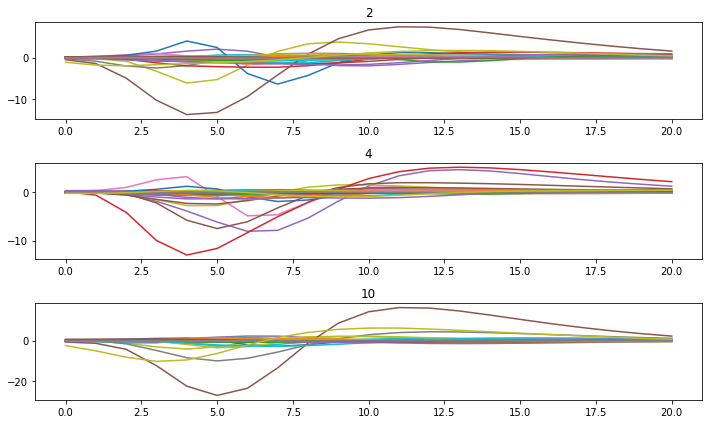

In [17]:
plot.grid_from_array(se.templates, axis=0, elements=[2, 4, 10], figsize=(10, 6),
                     sharey=False)

In [16]:
from yass.geometry import make_channel_index

In [17]:
ch_index = make_channel_index(re.neigh_matrix, re.geom)

In [18]:
n_templates, waveform_length, n_channels = templates.shape

small_templates = np.empty((n_templates, waveform_length, 7))

for i in range(n_templates):
    main_channel = main_channels[i]
    neighbors = ch_index[main_channel]
    small_templates[i] = templates[i][:, neighbors]

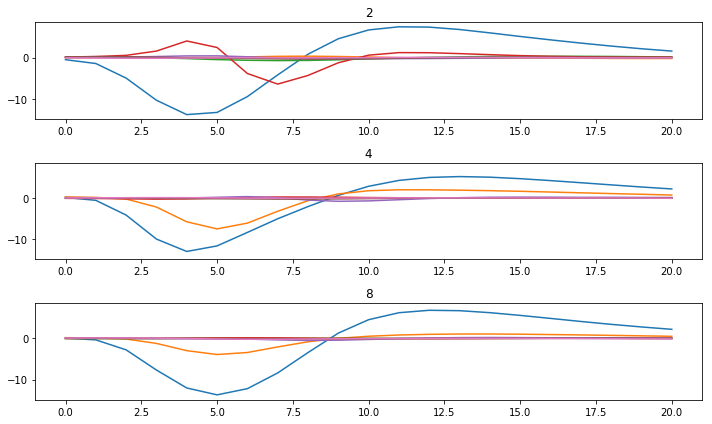

In [19]:
plot.grid_from_array(small_templates, axis=0, elements=[2, 4, 8], figsize=(10, 6), sharey=True)

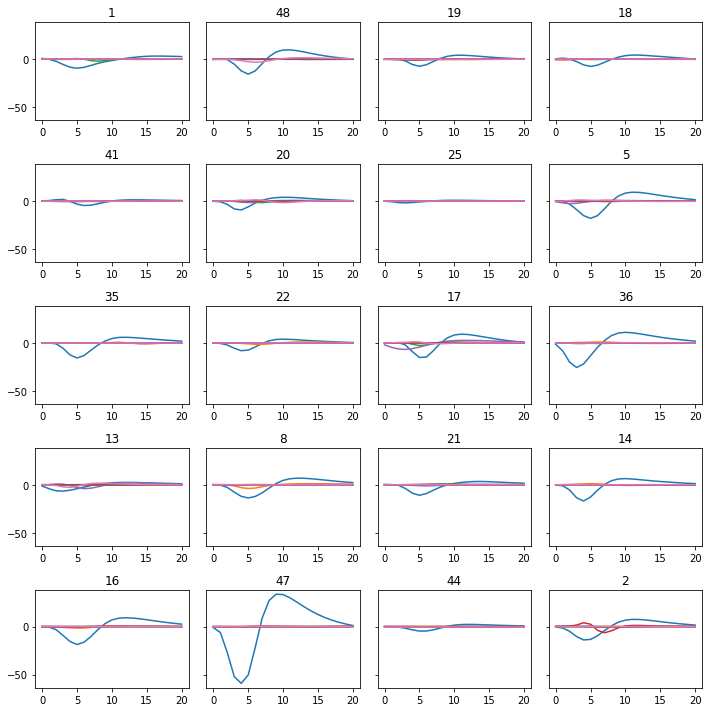

In [20]:
plot.grid_from_array(small_templates, axis=0, elements=20, figsize=(10, 10), sharey=True)

## Generating training data

In [21]:
# n_spikes = 50000
n_spikes = 10000

min_amplitude = 5
n_templates = np.max(gt[:,1]) + 1
chosen_templates = np.arange(n_templates)

data_folder = '/home/Edu/data/nnet/'

In [ ]:
(x_detect, y_detect,
 x_triage, y_triage,
 x_ae, y_ae) = make_training_data(CONFIG, gt, chosen_templates,
                                  min_amplitude, n_spikes,
                                  data_folder=data_folder,
                                  multi=True)

In [ ]:
print(f'Training set sizes:\n\tdetect:{x_detect.shape}\n\ttriage:{x_triage.shape}\n\tautoencoder:{x_ae.shape}')

In [ ]:
# compute amplitude for positive and negative samples in the detect training set
x_detect_positive = x_detect[y_detect == 1]
x_detect_negative = x_detect[y_detect == 0]

amps_positive = np.max(np.abs(x_detect_positive), axis=(1, 2))
amps_negative = np.max(np.abs(x_detect_negative), axis=(1, 2))

In [ ]:
plot.grid_from_array(x_detect_positive, axis=0,
                     elements=16, sharey=True)

In [ ]:
plot.grid_from_array(x_detect_negative, axis=0,
                     elements=16, sharey=True)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_positive, kde=False)

In [ ]:
plt.rcParams['figure.figsize'] = (10, 3)
_ = sns.distplot(amps_negative, kde=False)

In [ ]:
x_triage_positive = x_triage[y_triage == 1]
x_triage_negative = x_triage[y_triage == 0]

In [ ]:
print(x_triage_positive.shape, x_triage_negative.shape)

In [ ]:
plot.grid_from_array(x_triage_positive, axis=0, elements=16,
                     figsize=(10, 10), sharey=True)

In [ ]:
plot.grid_from_array(x_triage_negative, axis=0, elements=16,
                     figsize=(10, 10), sharey=True)

## make_training_data - line by line

In [22]:
import os
import numpy as np
import logging


from yass.augment.choose import choose_templates
from yass.augment.crop import crop_templates
from yass.augment.noise import noise_cov
from yass.augment.util import (make_noisy, make_clean, make_collided,
                               make_misaligned, make_noise)
from yass.templates.util import get_templates
from yass.util import load_yaml


path_to_data = os.path.join(data_folder, 'preprocess', 'standarized.bin')
path_to_config = os.path.join(data_folder, 'preprocess',
                                  'standarized.yaml')
PARAMS = load_yaml(path_to_config)

In [24]:
spike_train = gt

templates, _ = get_templates(
        np.hstack((spike_train,
                   np.ones((spike_train.shape[0], 1), 'int32'))),
        path_to_data,
        CONFIG.resources.max_memory,
        4*CONFIG.spike_size)

100%|██████████| 113/113 [00:03<00:00, 29.15it/s]


In [27]:
templates = np.transpose(templates, (2, 1, 0))

In [59]:
templates.shape

(18, 81, 49)

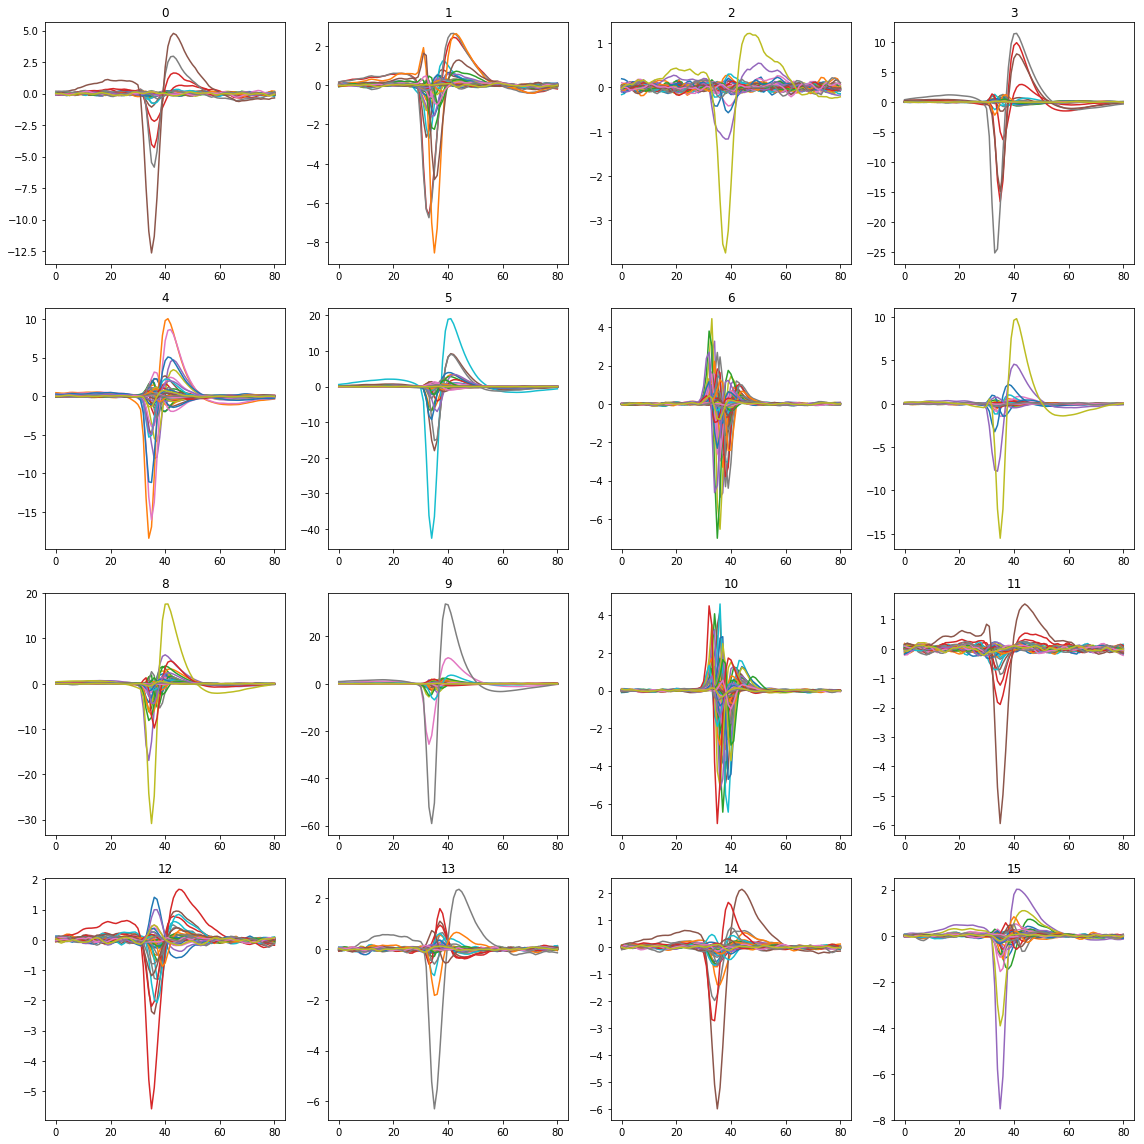

In [34]:
plot.grid_from_array(templates, axis=0, elements=range(16),
                     figsize=(16, 16), sharey=False)

In [35]:
templates = choose_templates(templates, chosen_templates)
templates_uncropped = np.copy(templates)

In [36]:
templates.shape

(18, 81, 49)

In [68]:
templates = crop_templates(templates, CONFIG.spike_size,
                           CONFIG.neigh_channels, CONFIG.geom)

In [69]:
templates.shape

(18, 61, 7)

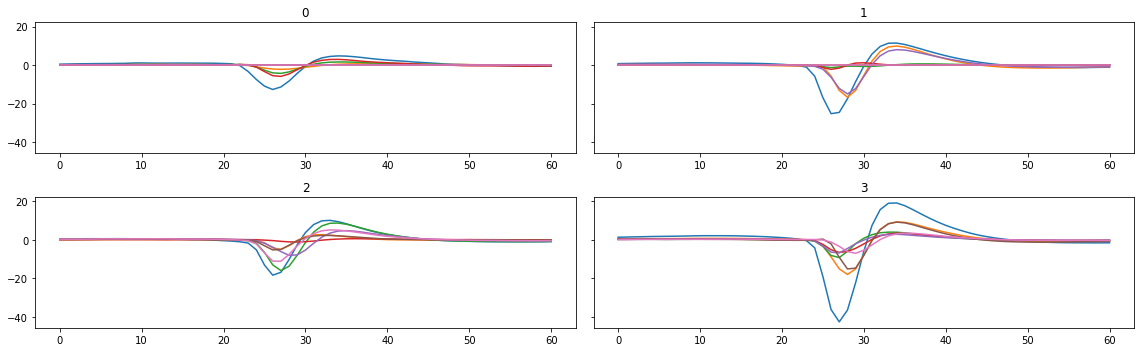

In [71]:
plot.grid_from_array(templates, axis=0, elements=range(4),
                     figsize=(16, 5), sharey=True)

In [72]:
# make training data set
K = templates.shape[0]
R = CONFIG.spike_size
amps = np.max(np.abs(templates), axis=1)

# make clean augmented spikes
nk = int(np.ceil(n_spikes/K))
max_amp = np.max(amps)*1.5
nneigh = templates.shape[2]
max_shift = 2*R

In [73]:
templates.shape

(18, 61, 7)

In [74]:
# make clean spikes
x_clean = make_clean(templates, min_amplitude, max_amp, nk)

In [75]:
x_clean.shape

(10008, 61, 7)

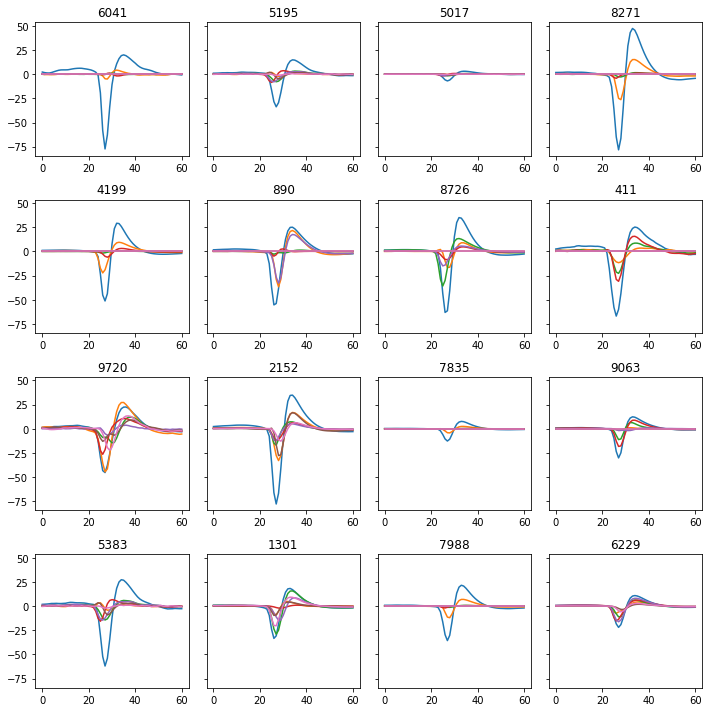

In [76]:
plot.grid_from_array(x_clean, axis=0, elements=16, figsize=(10, 10), sharey=True)

In [77]:
noise_ratio=10
collision_ratio=1
misalign_ratio=1
misalign_ratio2=1
multi_channel=True

In [78]:
x_collision = make_collided(x_clean, collision_ratio, templates_cropped,
                            R, multi_channel, nneigh)

In [79]:
x_collision.shape

(10008, 61, 7)

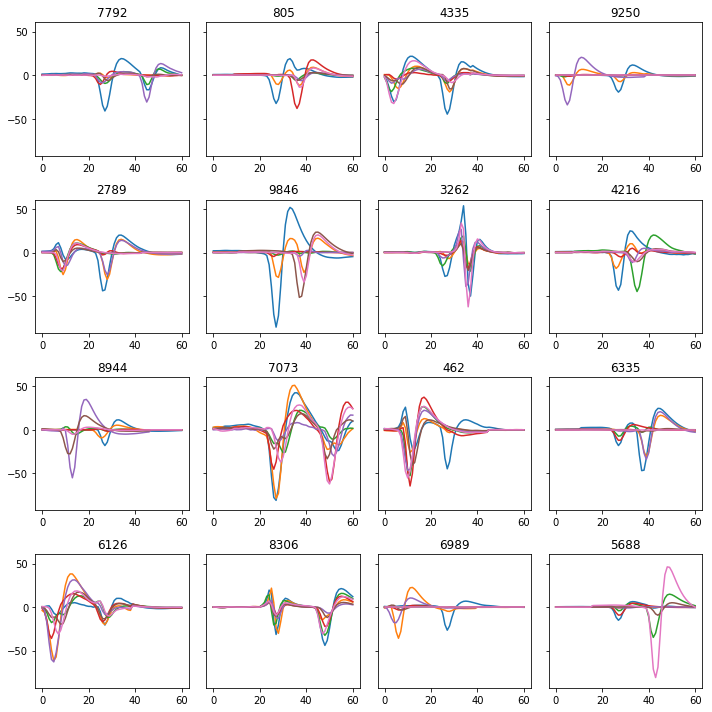

In [80]:
plot.grid_from_array(x_collision, axis=0, elements=16, figsize=(10, 10), sharey=True)

# Training

In [ ]:
n_iter = 5000

## Detector training

In [ ]:
detect_name = path.join('models', 'detect-'+util.directory()+'.ckpt')
filters_detect = [8, 4]

_, waveform_length, n_neighbors =  x_detect.shape

detector = NeuralNetDetector(detect_name, filters_detect,
                             waveform_length, n_neighbors,
                             threshold=0.5,
                             channel_index=CONFIG.channel_index,
                             n_iter=n_iter)

detector.fit(x_detect, y_detect)

## Triage training

In [ ]:
triage_name = path.join('models', 'triage-'+util.directory()+'.ckpt')
filters_triage = [8, 4]

_, waveform_length, n_neighbors = x_triage.shape

triage = NeuralNetTriage(triage_name, filters_triage,
                         waveform_length=waveform_length,
                         threshold=0.5,
                         n_neighbors=n_neighbors,
                         n_iter=n_iter)

triage.fit(x_triage, y_triage)

# Predict

In [ ]:
output_dir = 'tmp/'

(path_to_standarized,
 standarized_params,
 whiten_filter) = preprocess.run(output_directory=output_dir,
                                 if_file_exists='skip')

In [ ]:
explorer_std = RecordingExplorer(path_to_standarized,
                                 path_to_geom=None,
                                 spike_size=15, neighbor_radius=70)

In [ ]:
_data = explorer_std.reader.data
window_size = 10000
idx = gt[105963, 0]
data = _data[idx-window_size:idx+window_size, :]

## Detect predict

In [ ]:
output_names = ('spike_index', 'waveform', 'probability')

(spike_index, waveform,
 proba) = detector.predict(data, output_names=output_names)

In [ ]:
_ = plt.plot(data)

In [ ]:
_ = plt.plot(waveform[0, :])

In [ ]:
_ = plt.plot(proba)

## Triage predict

In [ ]:
# to_triage = waveform[:, :, :x_triage.shape[2]]
to_triage = small_templates

In [ ]:
idx_clean = triage.predict(to_triage)

In [ ]:
not_clean = np.where(~idx_clean)[0]

In [ ]:
not_clean

In [ ]:
plt.rcParams['figure.figsize'] = (10, 10)
plot.grid(small_templates, axis=0, elements=not_clean, sharey=False)